In [1]:
import os
import time
import datetime
import argparse
from yacs.config import CfgNode as CN

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from timm.utils import accuracy, AverageMeter

from data import build_dataset, build_external_dataset
from models import build_model
import logging

In [50]:
class RegModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.fc = [*self.model.children()][-1]
        self.squeeze = self.model.__class__.__name__ == 'SqueezeNet'

        self.hidden = {}
        self.hook_registered = False
        
    def _hook(self, _, input, output):
        device = input[0].device
        if output.dim() > 2:
            output = F.adaptive_avg_pool2d(output, (1, 1))
        self.hidden[device] = torch.flatten(output, 1)
    
    def _register_hook(self):
        layer = [*self.model.children()][-2]
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True
        
    def get_representation(self, x):
        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.model(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()
        return hidden
        
    def forward(self, x, return_representation=False):
        representation = self.get_representation(x)
        
        if self.squeeze:
            representation = representation.unsqueeze(-1).unsqueeze(-1)
            out = torch.flatten(self.fc(representation), 1)
        else:
            out = self.fc(representation)
        if return_representation:
            return (out, representation)
        else:
            return out
    
class Backbone(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.hidden = {}
        self.hook_registered = False
        
    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = torch.flatten(input[0], 1)
    
    def _register_hook(self):
        layer = [*self.model.children()][-1]
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True
        
    def forward(self, x, return_representation=False):
        if not self.hook_registered:
            self._register_hook()
            
        logits = self.model(x)
        repres = self.hidden[x.device]
        self.hidden.clear()
        if return_representation:
            return (logits, repres)
        else:
            return repres
    
    
def build_loaders(config, workers=1):
    if 'covidx' in config.DATA.DIR:
        test_set = build_dataset(split='test', config=config)
    else:
        test_set = build_external_dataset(config=config)
    
    test_loader = DataLoader(
        test_set, batch_size=config.DATA.BATCH_SIZE, shuffle=False, \
        num_workers=workers, pin_memory=True, drop_last=False)
    
    return test_loader


def build_logger(output_dir, log_name):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    fh = logging.FileHandler(os.path.join(output_dir, log_name), mode='w')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter("%(asctime)s - %(filename)s - %(levelname)s: %(message)s")
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    return logger


def build_load_model(config):
    model = build_model(config)
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad) / (1024 * 1024)
    print(f"Backbone: {config.MODEL.ARCH} -- Number of params: {n_parameters:.2f} MB")
    
    checkpoint = torch.load(config.MODEL.RESUME, map_location='cpu')
    model.load_state_dict(checkpoint['model'], strict=True)
    
    if config.MODEL.RESUME.__contains__('constraint'):
        model = RegModel(model)
    else:
        model = Backbone(model)
    
    del checkpoint
    torch.cuda.empty_cache()
    
    return model


@torch.no_grad()
def validate(model, loader, device='cpu', verbose=1, logger=None):
    model.eval()
    meter = AverageMeter()
    print(f'Load from {config.MODEL.RESUME}')
    if logger is not None:
        logger.info(f'Load from {config.MODEL.RESUME}')
    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        acc = accuracy(logits, labels, topk=(1,))[0]
        meter.update(acc.item(), labels.size(0))
        if verbose > 0 and (batch_idx+1) % verbose == 0:
            print(f'[{batch_idx}/{len(loader)}]: {meter.avg:.2f}')
            if logger is not None:
                logger.info(f'[{batch_idx}/{len(loader)}]: {meter.avg:.2f}')
            
    print(f'{config.MODEL.RESUME} : {meter.avg:.2f}')
    if logger is not None:
        logger.info(f'{config.MODEL.RESUME} : {meter.avg:.2f}')
        

@torch.no_grad()
def get_representations(model, loader, device='cpu', verbose=10):
    model.eval()
    y_true = torch.LongTensor(0)
    representations = torch.FloatTensor(0)
    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        _, repres = model(imgs, return_representation=True)
        y_true = torch.cat([y_true, labels.cpu()])
        representations = torch.cat([representations, repres.cpu()])
        if (batch_idx+1) % verbose == 0:
            print(f'[{batch_idx} / {len(loader)}]')
    return y_true, representations

In [51]:
SEED = 4
MODEL_ARCH = 'densenet121'
BATCH_SIZE = 128
AUG_LEVEL = 4
CONSTRAINT_TYPE = None
DEVICE = 'cpu'

if CONSTRAINT_TYPE is None:
    CFG_FILE = 'configs/general_config_level.yaml'
    RESUME_FILE = f'output/{SEED}/{MODEL_ARCH}/level_{AUG_LEVEL}/ckpt_{MODEL_ARCH}.pth'
elif CONSTRAINT_TYPE == 'BYOL-pretrain':
    CFG_FILE = 'configs/general_config_level.yaml'
    RESUME_FILE = f'output/{SEED}/{MODEL_ARCH}/level_{AUG_LEVEL}_BYOL_pretrain/ckpt_{MODEL_ARCH}.pth'
elif CONSTRAINT_TYPE == 'linear_eval':
    CFG_FILE = 'configs/general_config_level.yaml'
    RESUME_FILE = f'output/SSL/{SEED}/{model_arch}/level_{AUG_LEVEL}/ckpt_{model_arch}.pth'
else:
    CFG_FILE = 'configs/cfg_constraint_level.yaml'
    RESUME_FILE = f'output/constraint/{SEED}/{MODEL_ARCH}/{CONSTRAINT_TYPE}_level_{AUG_LEVEL}/ckpt_{MODEL_ARCH}.pth'

config = CN.load_cfg(open(CFG_FILE, 'r'))
config.AUG.LEVEL = AUG_LEVEL
config.MODEL.ARCH = MODEL_ARCH
config.MODEL.RESUME = RESUME_FILE

model = build_load_model(config)
model = model.to(DEVICE)

test_loader = build_loaders(config, workers=1 if DEVICE=='cpu' else 16)

y_true_densenet, representations_densenet = get_representations(model, test_loader, device=DEVICE, verbose=10)

Backbone: densenet121 -- Number of params: 6.63 MB
[9 / 201]
[19 / 201]
[29 / 201]
[39 / 201]
[49 / 201]
[59 / 201]
[69 / 201]
[79 / 201]
[89 / 201]
[99 / 201]
[109 / 201]
[119 / 201]
[129 / 201]
[139 / 201]
[149 / 201]
[159 / 201]
[169 / 201]
[179 / 201]
[189 / 201]
[199 / 201]


In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import manifold

def tsne_visualize(y_true, repres1, repres2, n_samples_per_class=0, perplexity=20, learning_rate=200, n_iter=2000, init='pca', alpha=0.2):
    
    if n_samples_per_class > 0:
        idxs = np.empty(0, dtype=int)
        for i in range(3):
            i_idx = np.random.choice(np.where(y_true==i)[0], n_samples_per_class)
            idxs = np.concatenate((idxs, i_idx))
        y_true, repres1, repres2 = y_true[idxs], repres1[idxs], repres2[idxs]
        
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init=init)
    print('without SR')
    y_2d_1 = tsne.fit_transform(X=repres1, y=y_true)
    print('with SR')
    y_2d_2 = tsne.fit_transform(X=repres2, y=y_true)
    
    df_no_sr = pd.DataFrame({
        'class': y_true,
        'tsne-x': y_2d_1[:, 0],
        'tsne-y': y_2d_1[:, 1]
    })
    
    df_sr = pd.DataFrame({
        'class': y_true,
        'tsne-x': y_2d_2[:, 0],
        'tsne-y': y_2d_2[:, 1]
    })
    
    plt.figure(1)
    plt.subplot(1, 2, 1)
    sns.scatterplot(x="tsne-x", y="tsne-y", hue="class", data=df_no_sr, alpha=alpha, palette="deep", edgecolor='none', s=10)
#     sns.scatterplot(x="tsne-x", y="tsne-y", hue="class", data=df_no_sr, alpha=alpha, palette="deep", style='class')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    sns.scatterplot(x="tsne-x", y="tsne-y", hue="class", data=df_sr, alpha=alpha, palette="deep", edgecolor='none', s=10)
#     sns.scatterplot(x="tsne-x", y="tsne-y", hue="class", data=df_sr, alpha=alpha, palette="deep", style='class')
    plt.axis('off')
    

In [96]:
y_true = y_true.numpy()
representations_densenet = representations_densenet.numpy()
representations = representations.numpy()

In [ ]:
tsne_visualize(y_true, representations_densenet, representations, perplexity=20, learning_rate=200, n_iter=2000, init='pca')

without SR
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25658 samples in 0.022s...
[t-SNE] Computed neighbors for 25658 samples in 13.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25658
[t-SNE] Computed conditional probabilities for sample 2000 / 25658
[t-SNE] Computed conditional probabilities for sample 3000 / 25658
[t-SNE] Computed conditional probabilities for sample 4000 / 25658
[t-SNE] Computed conditional probabilities for sample 5000 / 25658
[t-SNE] Computed conditional probabilities for sample 6000 / 25658
[t-SNE] Computed conditional probabilities for sample 7000 / 25658
[t-SNE] Computed conditional probabilities for sample 8000 / 25658
[t-SNE] Computed conditional probabilities for sample 9000 / 25658
[t-SNE] Computed conditional probabilities for sample 10000 / 25658
[t-SNE] Computed conditional probabilities for sample 11000 / 25658
[t-SNE] Computed conditional probabilities for sample 12000 / 25658
[t-SNE] Computed conditional probabili

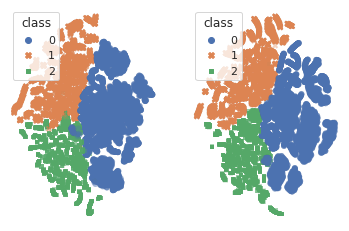

In [81]:
tsne_visualize(y_true, representations_densenet, representations, perplexity=30, learning_rate=200, n_iter=2000, init='pca')

without SR
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25658 samples in 0.029s...
[t-SNE] Computed neighbors for 25658 samples in 30.644s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25658
[t-SNE] Computed conditional probabilities for sample 2000 / 25658
[t-SNE] Computed conditional probabilities for sample 3000 / 25658
[t-SNE] Computed conditional probabilities for sample 4000 / 25658
[t-SNE] Computed conditional probabilities for sample 5000 / 25658
[t-SNE] Computed conditional probabilities for sample 6000 / 25658
[t-SNE] Computed conditional probabilities for sample 7000 / 25658
[t-SNE] Computed conditional probabilities for sample 8000 / 25658
[t-SNE] Computed conditional probabilities for sample 9000 / 25658
[t-SNE] Computed conditional probabilities for sample 10000 / 25658
[t-SNE] Computed conditional probabilities for sample 11000 / 25658
[t-SNE] Computed conditional probabilities for sample 12000 / 25658
[t-SNE] Computed conditional probabili

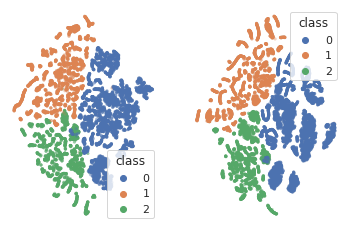

In [176]:
tsne_visualize(y_true, representations_densenet, representations, n_samples_per_class=0, perplexity=30, learning_rate=200, n_iter=10000, init='pca', alpha=0.2)

without SR
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25658 samples in 0.022s...
[t-SNE] Computed neighbors for 25658 samples in 26.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25658
[t-SNE] Computed conditional probabilities for sample 2000 / 25658
[t-SNE] Computed conditional probabilities for sample 3000 / 25658
[t-SNE] Computed conditional probabilities for sample 4000 / 25658
[t-SNE] Computed conditional probabilities for sample 5000 / 25658
[t-SNE] Computed conditional probabilities for sample 6000 / 25658
[t-SNE] Computed conditional probabilities for sample 7000 / 25658
[t-SNE] Computed conditional probabilities for sample 8000 / 25658
[t-SNE] Computed conditional probabilities for sample 9000 / 25658
[t-SNE] Computed conditional probabilities for sample 10000 / 25658
[t-SNE] Computed conditional probabilities for sample 11000 / 25658
[t-SNE] Computed conditional probabilities for sample 12000 / 25658
[t-SNE] Computed conditional probabili

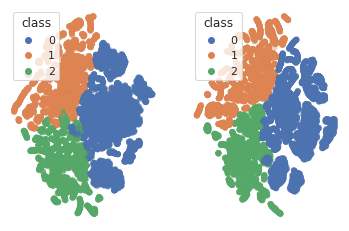

In [86]:
tsne_visualize(y_true, representations_densenet, representations, perplexity=30, learning_rate=500, n_iter=2000, init='pca')

without SR
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25658 samples in 0.023s...
[t-SNE] Computed neighbors for 25658 samples in 27.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25658
[t-SNE] Computed conditional probabilities for sample 2000 / 25658
[t-SNE] Computed conditional probabilities for sample 3000 / 25658
[t-SNE] Computed conditional probabilities for sample 4000 / 25658
[t-SNE] Computed conditional probabilities for sample 5000 / 25658
[t-SNE] Computed conditional probabilities for sample 6000 / 25658
[t-SNE] Computed conditional probabilities for sample 7000 / 25658
[t-SNE] Computed conditional probabilities for sample 8000 / 25658
[t-SNE] Computed conditional probabilities for sample 9000 / 25658
[t-SNE] Computed conditional probabilities for sample 10000 / 25658
[t-SNE] Computed conditional probabilities for sample 11000 / 25658
[t-SNE] Computed conditional probabilities for sample 12000 / 25658
[t-SNE] Computed conditional probabili

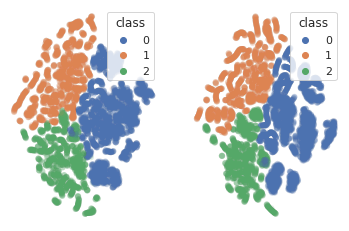

In [88]:
tsne_visualize(y_true, representations_densenet, representations, perplexity=30, learning_rate=500, n_iter=5000, init='pca')

In [ ]:
# perplexity=100, learning_rate=200, n_iter=1000 KLD 64.843140
# perplexity=50,  learning_rate=200, n_iter=1000 KLD 68.292938
# perplexity=20,  learning_rate=200, n_iter=1000 KLD 1.131679
# perplexity=20,  learning_rate=200, n_iter=5000 KLD 0.714057


# perplexity=30,  learning_rate=200, n_iter=2000 KLD 0.801589
# perplexity=20,  learning_rate=200, n_iter=2000 KLD 0.820929
# perplexity=10,  learning_rate=200, n_iter=2000 KLD 0.900464

In [132]:
from sklearn.cluster import KMeans
from scipy.stats import mode

kmeans = KMeans(n_clusters=3, max_iter=500, n_init=20)
# clusters = kmeans.fit_predict(representations_densenet)
clusters = kmeans.fit_predict(representations)

y_pred_kmeans = np.zeros_like(y_true)
for i in range(10):
    mask = (clusters == i)
    y_pred_kmeans[mask] = mode(y_true[mask])[0]
    
sum(y_pred_kmeans == y_true) / len(y_true) * 100

99.36472055499259